In [6]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.ensemble import RandomForestRegressor

In [7]:
jax.default_backend()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


'cpu'

In [8]:
#generate data

x_s = np.linspace(-4,4, 20)
y_s = np.linspace(-4,4, 20)
theta_s = np.linspace(0.001,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    X.append(state)

X_grid = np.array(X)
y_grid = np.array(y)
len(X_grid)


6000

In [9]:
X_grid

array([[-4.00000000e+00, -4.00000000e+00,  1.00000000e-03],
       [-4.00000000e+00, -4.00000000e+00,  4.49727522e-01],
       [-4.00000000e+00, -4.00000000e+00,  8.98455044e-01],
       ...,
       [ 4.00000000e+00,  4.00000000e+00,  5.38573026e+00],
       [ 4.00000000e+00,  4.00000000e+00,  5.83445779e+00],
       [ 4.00000000e+00,  4.00000000e+00,  6.28318531e+00]])

In [10]:


def uniform_samples(env, n):

    state = env.reset()
    X_rand = []
    for i in range(n):
        state = env.reset()
        X_rand.append(state)
        for action in range(env.action_space.n):
            next_state, reward, done, _ = env.step(state, action, update_env=False)
            X_rand.append(next_state)
    return np.array(X_rand)


X_samples = uniform_samples(env, 1000)
X_val = uniform_samples(env,2000)


In [11]:
X = np.vstack([X_grid])
#np.random.shuffle(X)
#X = np.flip(X,0)
len(X)

6000

In [12]:
ys = [env.get_reward(x) for x in X]
    
ys = np.array(ys)

In [13]:
def plot_surface(X_in,env, file_name=None, y_pred=None, ys=None):
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [15, 12]

    # Plot...
    plt.scatter(X_in[:,0], X_in[:,1], s=1) # s is a size of marker 
    plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
    plt.gca().add_artist(obstacle)
    plt.gca().add_artist(goal)


    arrow_len = env.v_max
    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(X_in[:,2])
    arrow_dy = arrow_len * np.sin(X_in[:,2])

    if len(y_pred)>0:
        arrow_colors = cm.jet((y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred)))
        print('l')
    elif len(ys)>0:
        arrow_colors = cm.get_cmap('jet', 3)(ys+1)

    else:
        arrow_colors = 'k'


    plt.quiver(X_in[:,0], X_in[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


    plt.jet()
    #plt.show()
    if file_name:
        plt.savefig(file_name)
    #plt.show()


In [14]:
len(X)

6000

In [15]:
right = 2*np.pi
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi


env.step(np.array([-4,-4,right]),2)

(array([-3.89434543, -3.77342305,  1.13446401]), 0, False, {})

In [18]:
env.step(np.array([-1,1,0]),1)

(array([0, 1, 0]), 1, True, {})

In [ ]:
X_grid[-1]

array([4.        , 4.        , 6.28318531])

In [ ]:

env.step(X_grid[0],2)

(array([-3.86083512, -3.70077912,  1.13546401]), 0, False, {})

In [ ]:
ys[-1]

-1

In [ ]:
X_grid[0]

array([-4.e+00, -4.e+00,  1.e-03])

l


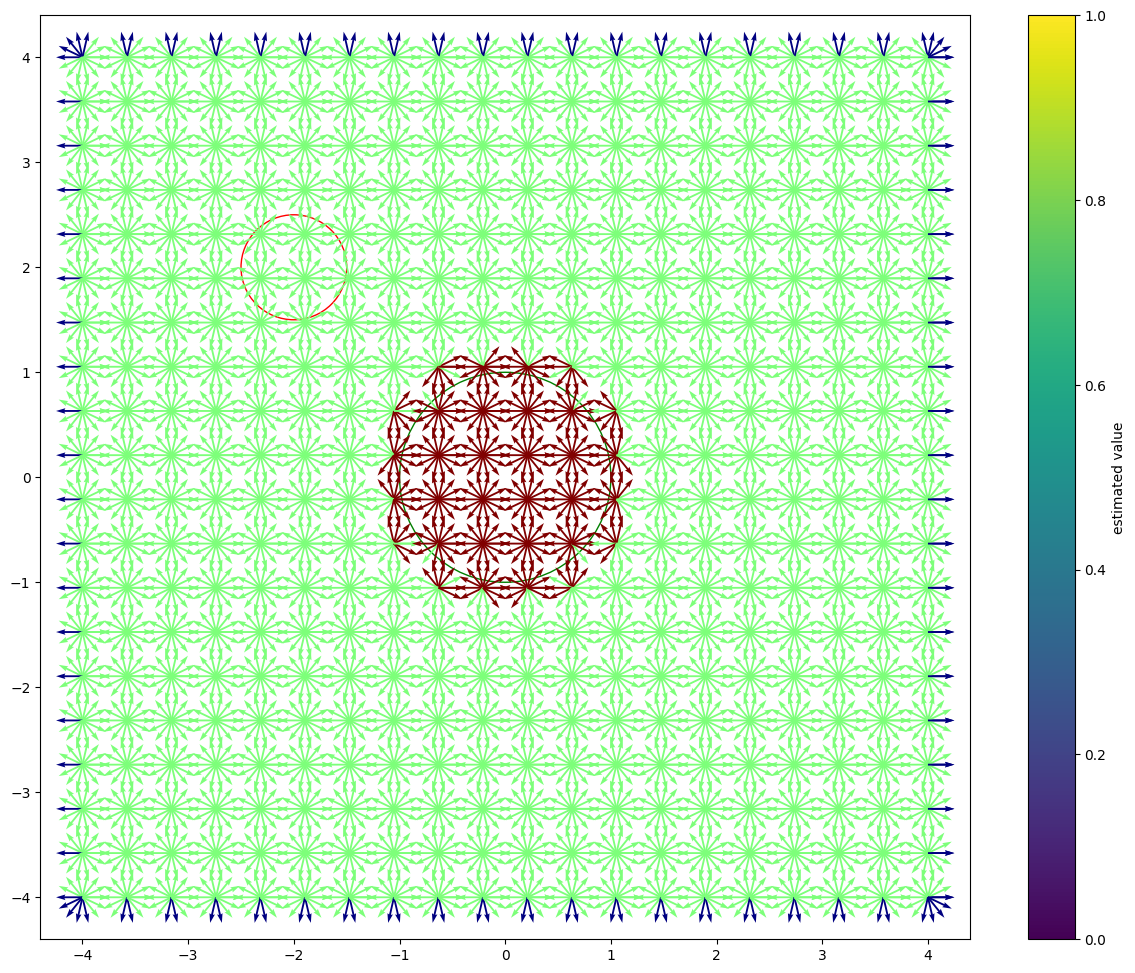

In [17]:
plot_surface(X, env, None, ys, [])

TypeError: object of type 'NoneType' has no len()

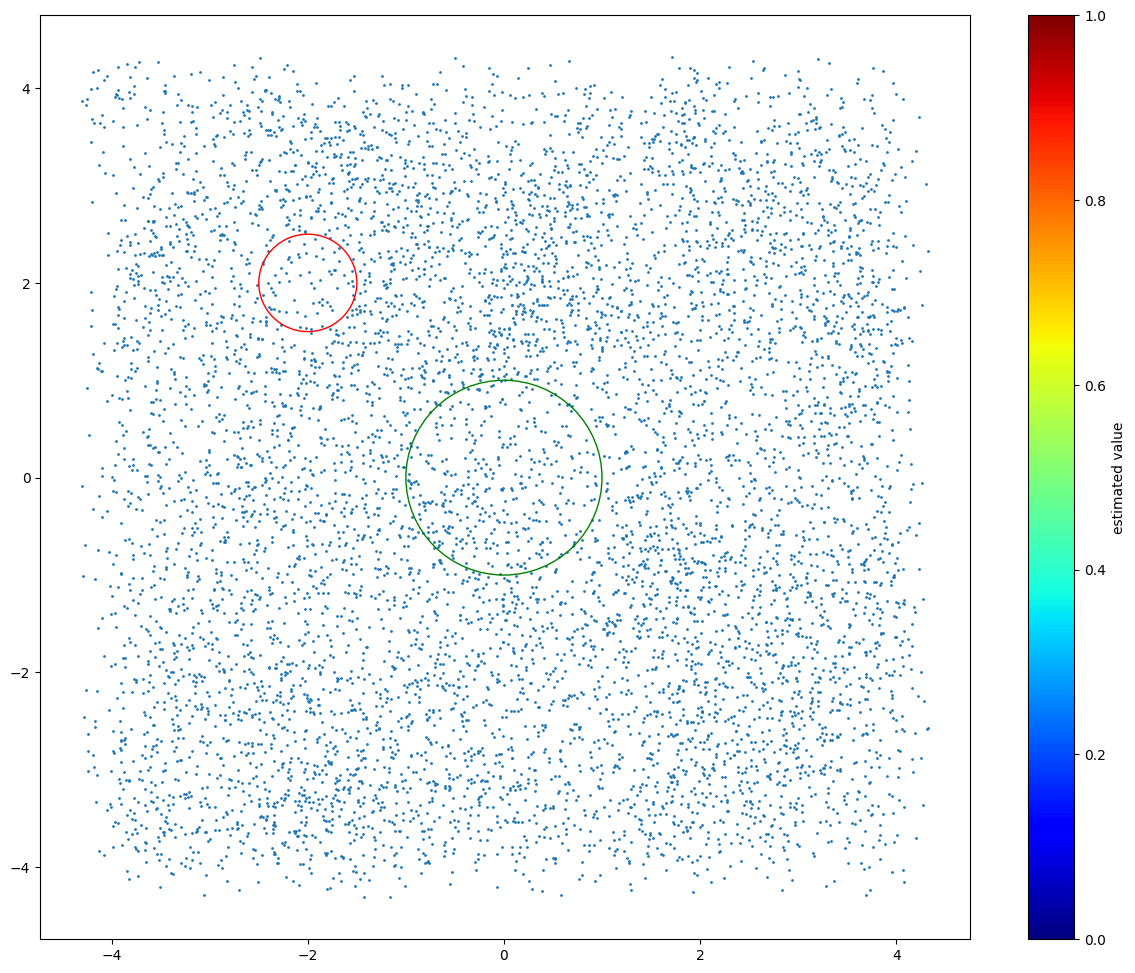

In [219]:
plot_surface(X_val, env, ys=[])

In [19]:
X3 = X.copy()
X_val3 = X_val.copy()
X = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X)))
X_val = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))




In [20]:
regr = RandomForestRegressor(max_depth=16, random_state=0)
regr.fit(X, ys)

RandomForestRegressor(max_depth=16, random_state=0)

In [21]:
y_pred = regr.predict(X)

l


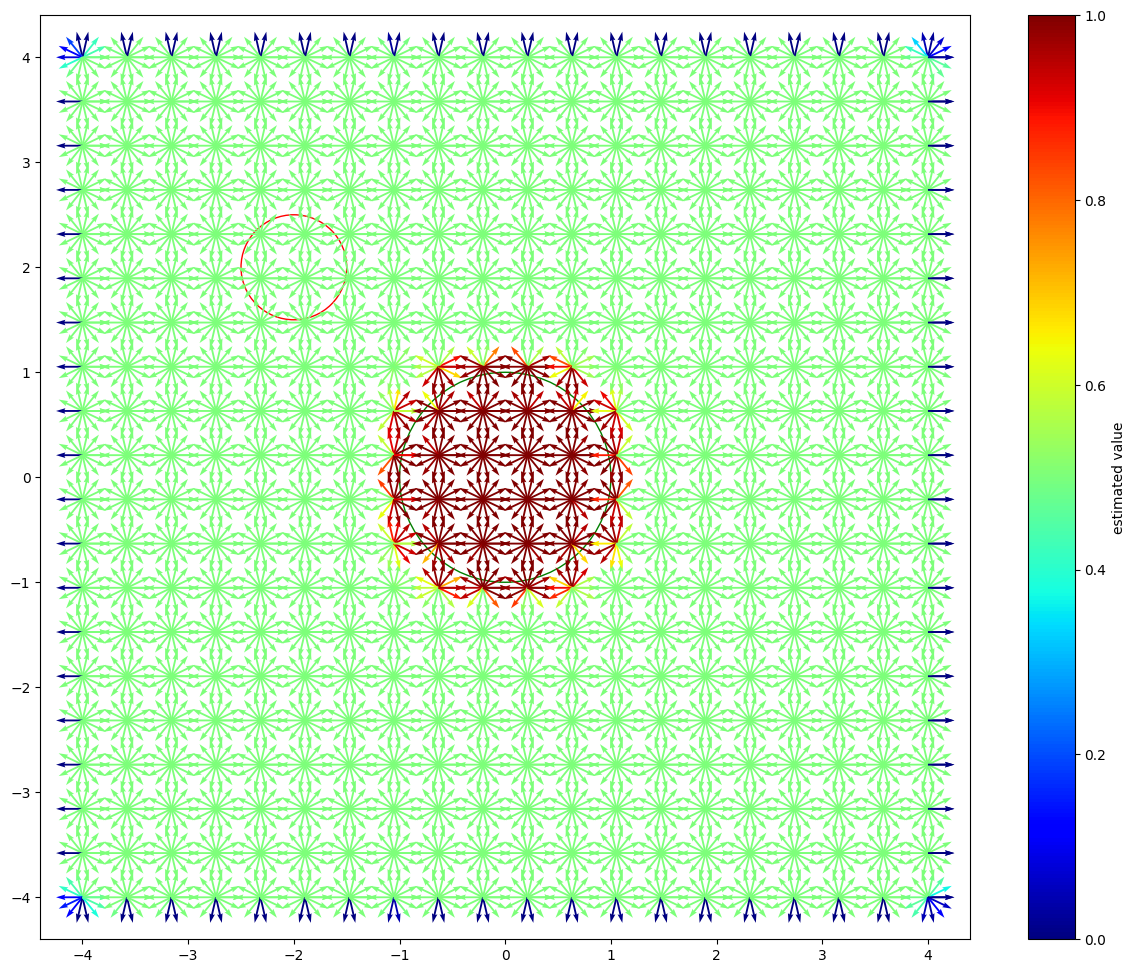

In [22]:
plot_surface(X3, env, 'experiment.png', y_pred)

In [25]:


#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(64)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(32)(l2)
#     l4 = jax.nn.relu(l3)
#     l5= hk.Linear(1)(l4)

#     return l5
def forward(X):
    l1 = hk.Linear(64)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(64)(l2)
    l4 = jax.nn.relu(l3)
    l5 = hk.Linear(64)(l4)
    l6 = jax.nn.relu(l5)

    l7= hk.Linear(1)(l6)

    return l7

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse



optimizer = optax.adamw(learning_rate=10e-6)
batch_size = 100 #make it 200-50
losses = []
#check we aren't double using gradients
opt_state = optimizer.init(params)
for epoch in range(500):
    batch_loss = []
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = ys[batch:batch+batch_size]
    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        #print("progress:", "epoch:", epoch, "batch loss",loss)
        batch_loss.append(loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    losses.append(np.mean(batch_loss))
    print('epoch', epoch, 'average loss', np.mean(batch_loss))
        
    
    
# After training
print("estimation of the parameters:")
print(params)

# estimate  = forward(X=env.reset(), params=params)
# print("estimate", estimate)

epoch 0 average loss 0.4632356
epoch 1 average loss 0.4159772
epoch 2 average loss 0.3710933
epoch 3 average loss 0.3305416
epoch 4 average loss 0.29472354
epoch 5 average loss 0.26338232
epoch 6 average loss 0.23607996
epoch 7 average loss 0.21242513
epoch 8 average loss 0.19217852
epoch 9 average loss 0.17495896
epoch 10 average loss 0.16035526
epoch 11 average loss 0.1480074
epoch 12 average loss 0.13757554
epoch 13 average loss 0.12877916
epoch 14 average loss 0.12136495
epoch 15 average loss 0.11511744
epoch 16 average loss 0.10985131
epoch 17 average loss 0.10542022
epoch 18 average loss 0.10169438
epoch 19 average loss 0.09856374
epoch 20 average loss 0.09593013
epoch 21 average loss 0.09370904
epoch 22 average loss 0.09183124
epoch 23 average loss 0.090246566
epoch 24 average loss 0.088902704
epoch 25 average loss 0.08775069
epoch 26 average loss 0.086755864
epoch 27 average loss 0.085888125
epoch 28 average loss 0.08512067
epoch 29 average loss 0.084437616
epoch 30 average los

KeyboardInterrupt: 

l


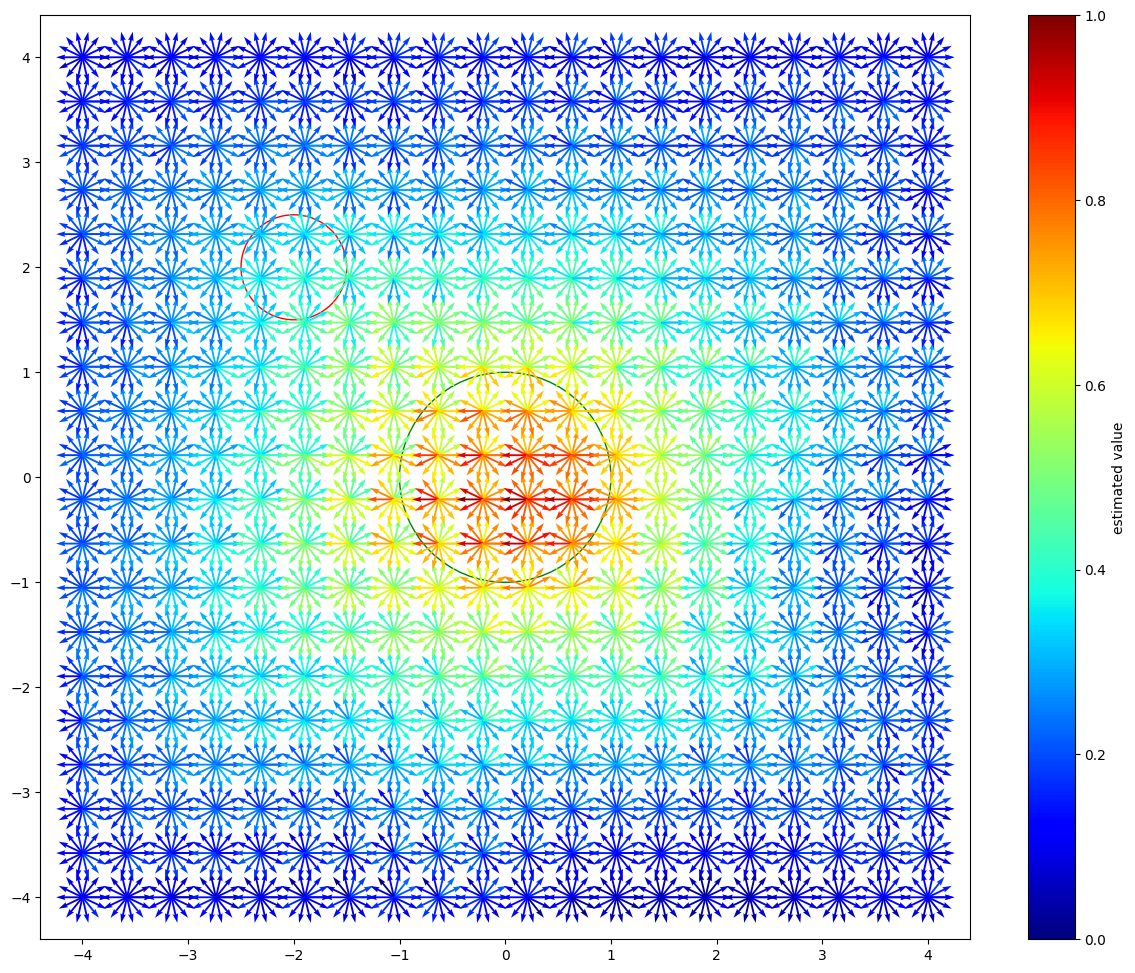

In [26]:
y_train = [forward(X=x, params=params) for x in X]
plot_surface(X3, env, 'experiment.png', y_train)

In [151]:

def forward(X):
    l1 = hk.Linear(12)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(4)(l2)
    l4 = jax.nn.relu(l3)
    l5 = hk.Linear(4)(l4)
    l6 = jax.nn.relu(l5)

    l7= hk.Linear(1)(l6)

    return l7

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse




optimizer = optax.adamw(learning_rate=10e-5)
batch_size = 5 #make it 200
losses = [np.inf]
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)
gamma = 0.8

@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

FIRST = True

for epoch in range(100):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]


        if False:
            y_batch = ys[batch:batch+batch_size]
            #print(np.unique(y_batch, return_counts=True))
        else:
            y_batch = env.sample_value_iter(X_batch, forward, params, gamma=gamma)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    FIRST = True
    epoch_loss /= (len(X) // batch_size)

    y_val = env.sample_value_iter(X_val, forward, params, gamma=gamma)

    val_loss = loss_fn(params, X_val, y_val)
    print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    if val_losses[-1] - val_loss < 0.001:
        print("early stopping",val_losses[-1] - val_loss)
        break
    val_losses.append(val_loss)


    print('epoch', epoch, 'average loss', epoch_loss, 'epoch delta', np.abs(epoch_loss - losses[-1]))
    losses.append(epoch_loss)

#todo impolement val set for early stopping


val_loss 0.30914664 delta inf
epoch 0 average loss 0.51183903 epoch delta inf
val_loss 0.33544406 delta 0.02629742
early stopping -0.02629742


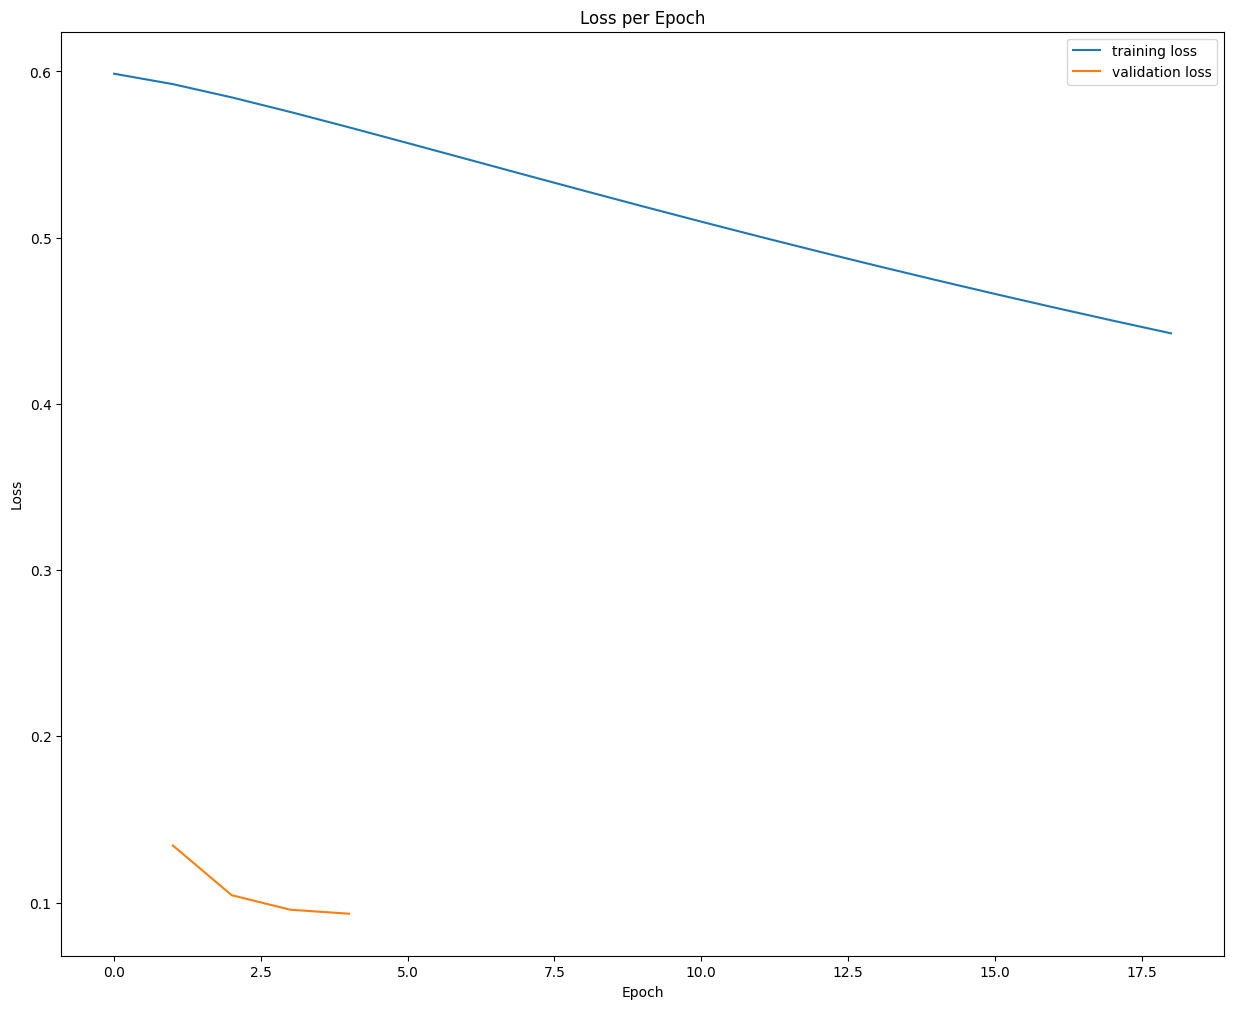

In [374]:
# Plot the losses
%matplotlib inline

lo = [l for l in losses]
vlo = [l for l in val_losses]


plt.plot(lo, label='training loss')
plt.plot(vlo, label='validation loss')

# Add a title and labels to the x and y axis
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
plt.savefig('losses_3.png')

plt.show()

In [20]:
#generate data

x_s = np.linspace(-4,4, 20)
y_s = np.linspace(-4,4, 20)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid_test = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X_test = []
for i in range(len(grid_test)):
    state = env.set(grid_test[i][0], grid_test[i][1], grid_test[i][2])
    X_test.append(state)

X_test = np.array(X_test)

X_test_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_test)))
X_test_encoded

/ifs/CS/replicated/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


array([[-4.0000000e+00, -4.0000000e+00,  1.0000000e+00,  0.0000000e+00],
       [-4.0000000e+00, -4.0000000e+00,  9.0096885e-01,  4.3388376e-01],
       [-4.0000000e+00, -4.0000000e+00,  6.2348980e-01,  7.8183150e-01],
       ...,
       [ 4.0000000e+00,  4.0000000e+00,  6.2348962e-01, -7.8183162e-01],
       [ 4.0000000e+00,  4.0000000e+00,  9.0096885e-01, -4.3388376e-01],
       [ 4.0000000e+00,  4.0000000e+00,  1.0000000e+00,  1.7484555e-07]],
      dtype=float32)

In [28]:



#y_pred = [forward(X=x, params=params) for x in X_test_encoded]
y_pred = regr.predict(X_test_encoded)

In [29]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
max(y_pred)

20.25302659875238

In [31]:
min(y_pred)

0.0

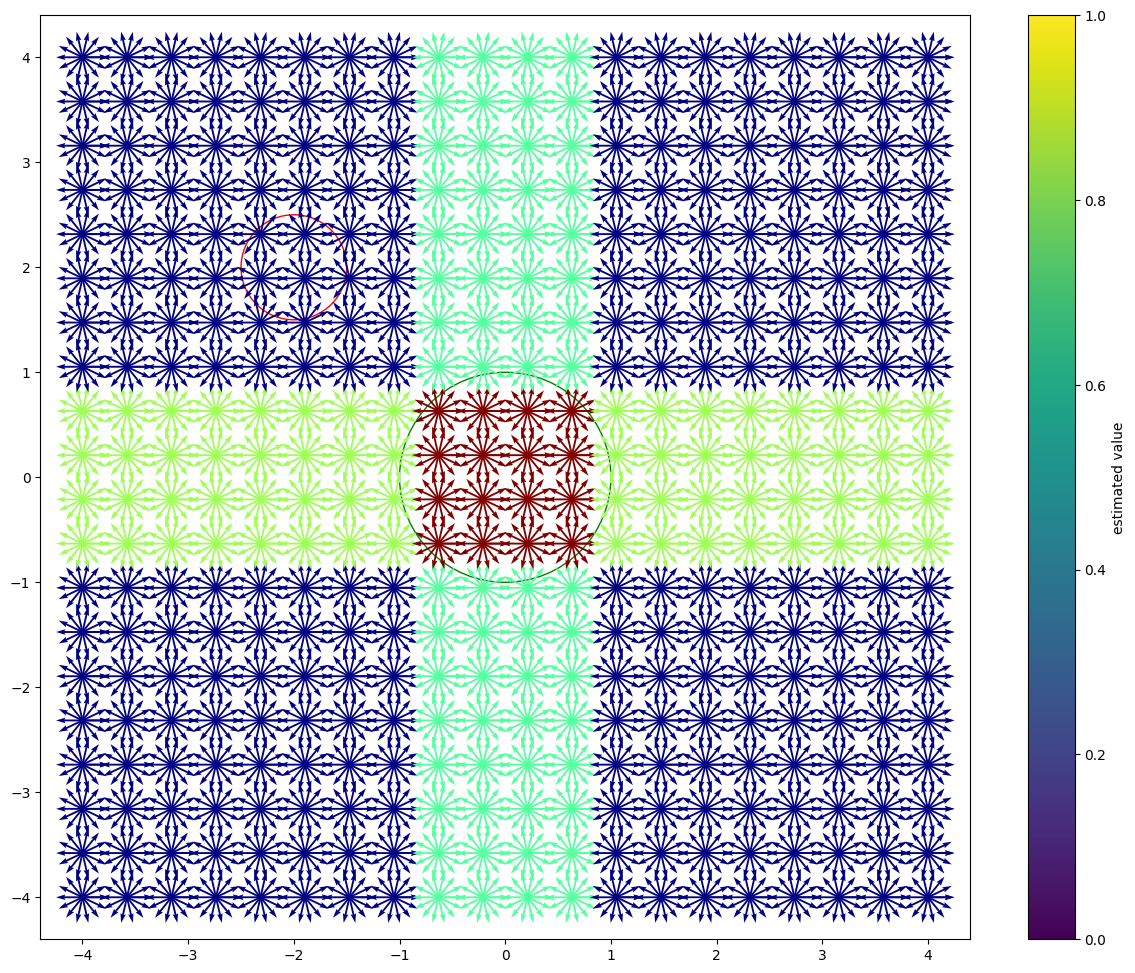

In [32]:
plot_surface(X_test, env, 'experiment.png', y_pred)

In [152]:
y_train = [forward(X=x, params=params) for x in X]

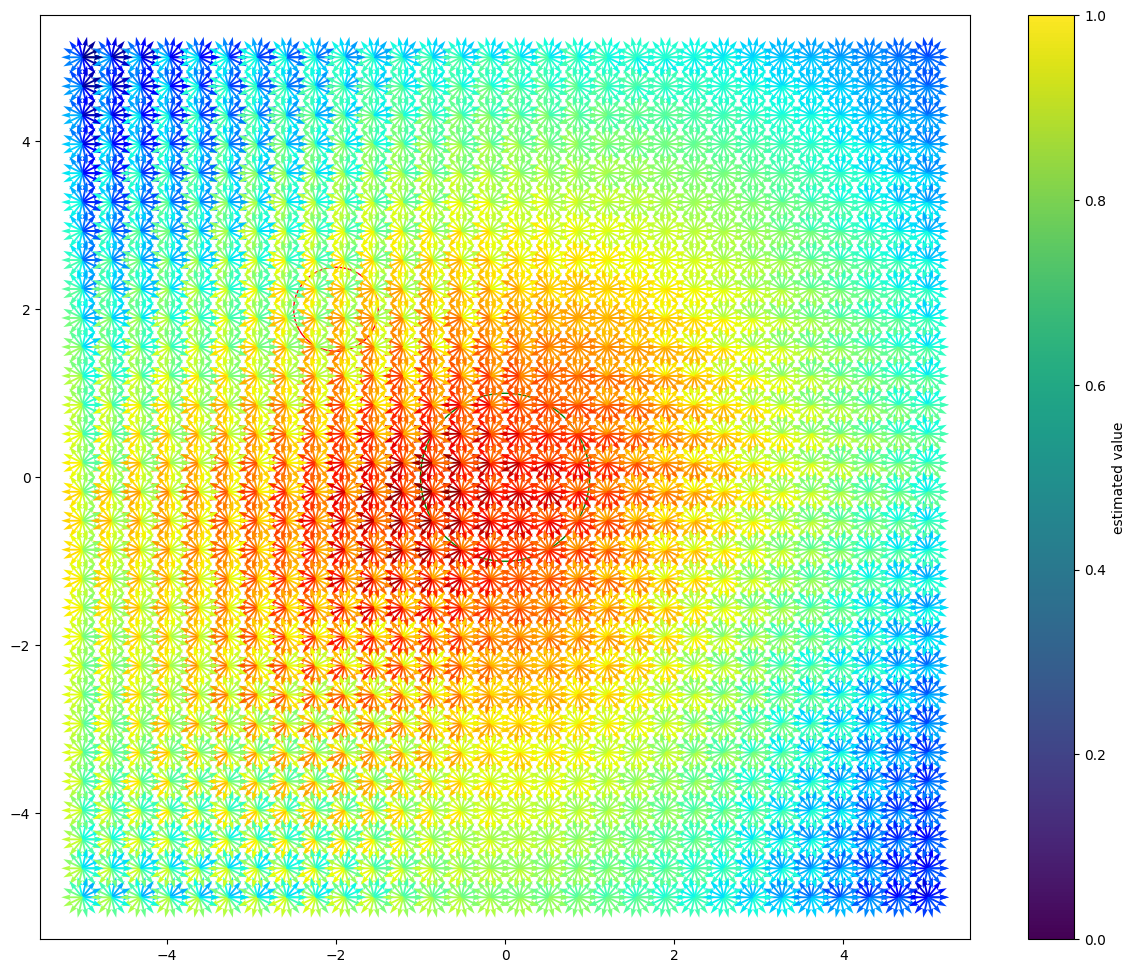

In [153]:
plot_surface(X3, env, 'experiment.png', y_train)

In [152]:
#train on small steps, run on bigger steps?
right = 0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
state = env.set(-3.9,2, down)
#state = env.reset()

gamma = gamma
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, a, update_env=False)
        #estimate = forward(X=next_state, params=params)
        estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)

        value = reward + gamma*estimate[0]


        possible_actions.append(value)

    action = np.argmax(np.array(possible_actions))
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
    
env.make_gif()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

ValueError: 'linear/w' with retrieved shape (4, 12) does not match shape=[3, 12] dtype=dtype('float32')

In [ ]:
10*estimate

Array([-31.93895], dtype=float32)

: 

In [ ]:
possible_actions

[Array(-12.71481, dtype=float32),
 Array(-12.356915, dtype=float32),
 Array(-12.71481, dtype=float32)]

: 

In [ ]:
np.argmax(possible_actions)

1

: 

In [394]:
forward(X=np.array([-4,-4,1, 1]), params=params) 

Array([1.237214], dtype=float32)

In [393]:
forward(X=np.array([0,0,1, 0]), params=params) 

Array([0.08173393], dtype=float32)

In [392]:
env.step(np.array([0,0,np.pi]), 0, update_env=False)

(array([2.50000000e-01, 4.37113883e-08, 2.00712864e+00]), 100, True, {})

In [166]:
X[0]

array([ 1.8830727 , -1.7482759 ,  0.23815954, -0.97122604], dtype=float32)